In [1]:
import numpy as np
import time

from triqs.gf import *
from triqs.gf.meshes import MeshDLRImFreq
from triqs_tprf.lattice import inv

from itertools import product
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from gwsolver import GWSolver
from exact_diag import exact_diag, ed_occupation, ed_mu, exact_diag_v
from pino import exact_g, analytical_g

from hubbard import GWHubbardDimer


matplotlib.rcParams.update({'font.size': 22})

Starting serial run at: 2024-03-20 18:46:45.278880


In [2]:
def plot(a, b, spin = 'up'):
    orbitals = len(a[spin].data[0, 0, :])
    fig, axs = plt.subplots(orbitals, orbitals, figsize = (10 * orbitals, 10 * orbitals), facecolor = 'black')
    spin = 'up'


    for i in range(orbitals):
        for j in range(orbitals):
            axs[i, j].set_facecolor('black')
            axs[i, j].xaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'x', colors = 'white')
            axs[i, j].yaxis.label.set_color('white')
            axs[i, j].tick_params(axis = 'y', colors = 'white')
            axs[i, j].set_xlim(-5, 5)
            # axs[i, j].xaxis.label.set_fontsize(20)

            axs[i, j].scatter([w.imag for w in a.mesh.values()], a[spin].data[:, i, j].real, color = 'blue', zorder = 1, s = 20)
            axs[i, j].scatter([w.imag for w in a.mesh.values()], a[spin].data[:, i, j].imag, color = 'red', zorder = 1, s = 20)

            axs[i, j].plot([w.imag for w in b.mesh.values()], b[spin].data[:, i, j].real, color = 'white', zorder = 0)
            axs[i, j].plot([w.imag for w in b.mesh.values()], b[spin].data[:, i, j].imag, color = 'white', zorder = 0)




def symmetric_difference(omega, value, A):
    w_index = np.argmin(np.abs(omega - value))

    left_sum = np.sum(A[:w_index])
    right_sum = np.sum(A[w_index:])
    return left_sum - right_sum

def find_center_freq(g):
    omega = np.array([w for w in g.mesh.values()])
    A = spectral(g)

    w_step = 5.0

    w = 0
    difference = symmetric_difference(omega, w, A)
    last_difference = 2 * difference

    previous_direction = None
    iter = 0
    while abs(difference) > 0.0001:
        if abs(difference - last_difference) < 1e-6:
            break

        iter += 1
        if difference < 0:
            if previous_direction == 'decrement':
                w_step /= 2
            previous_direction = 'increment'
            w += w_step
        else:
            if previous_direction == 'increment':
                w_step /= 2
            previous_direction = 'decrement'
            w -= w_step

        last_difference = difference
        difference = symmetric_difference(omega, w, A)
    
    return w

def offset(g_w, w, w_center_arg):
    return np.argmin(np.abs(w - find_center_freq(g_w))) - w_center_arg

def spectral(g_w):
    A = 0
    for name, g in g_w:
        A += -np.imag(np.trace(g.data[:, :, :], axis1 = 1, axis2 = 2))
    return A

def generate_g0_w(tij, mesh, spin_names = ['up', 'dn']):
    g_inv = Gf(mesh = mesh, target_shape = np.shape(tij))
    g_inv << iOmega_n - tij.transpose()
    g = inv(g_inv, 8)
    return BlockGf(block_list = [g] * 2, name_list = spin_names, make_copies = False)

def coulomb_matrix(orbitals, U, non_local = True):
    Vij = np.zeros([orbitals] * 2)
    for i in range(orbitals):
        for j in range(orbitals):
            Vij[i, j] = round(0.75 * U / (abs(i - j) + 1), 2)

        Vij[i, i] = U
    if non_local:
        return Vij

    return np.diag(Vij.diagonal())

def coulomb_tensor(orbitals, U, non_local = True):
    Vij = coulomb_matrix(orbitals, U, non_local)
    Vijkl = np.zeros([orbitals] * 4)
    for i in range(orbitals):
        for j in range(orbitals):
            Vijkl[i, j, i, j] = Vij[i, j]
    return Vijkl

def spectral(g_w):
    A = 0
    for name, g in g_w:
        A += -np.imag(np.trace(g.data[:, :, :], axis1 = 1, axis2 = 2))
    return A

def N(g_w):
    return g_w.total_density().real

def GWtoED(orbitals, N_fix, t, U, beta = 20, max_iter = 1, non_local = False, N_tol = 1e-5, mu_0 = 0.0, mu_gw = 0.0, pade = False):

    def rel_error(ed, g):
        size = len(list(g.mesh.values()))
        errors = np.zeros((size, orbitals, orbitals)) * 1j
        for i, w in enumerate(g.mesh):
            ed = ED['up'](w)
            g_up = g['up'].data[i, :, :]
            errors[i] = (ed - g_up) / ed

        return 100 * np.max(np.abs(errors))

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    Vij = coulomb_matrix(orbitals, U, non_local = non_local)
    Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)

    iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)
    g0_w = generate_g0_w(tij, iw_mesh_f)

    ED, mu_1, mu_2 = exact_diag(tij, Vijkl, N_fix, beta = beta, nw = 1024, N_tol = N_tol, mu_0 = mu_0, mu_gw = mu_gw)

    gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, N_fix = False, max_iter = max_iter, full_mesh = pade, N_tol = N_tol, mu_0 = mu_1, mu_gw = mu_2)
    
    print(f'g0_w occupation: {round(N(gw.g0_w), 9)}, Chemical potential: {gw.mu_0}')
    print(f'g_w occupation: {round(N(gw.g_w), 9)}, Chemical potential: {gw.mu_gw}')
    print(f'ED occupation: {round(N(ED), 9)}, Chemical potential: {mu_1}')
    print(f'Max rel. error: {round(rel_error(ED, gw.g_w), 2)}%')
    print(f'Iteration reached: {gw.iter_reached}')
    # print(N(ED))
    # print(gw.mu)
    if not pade:
        plot(gw.g_w, ED)
        return

    w_mesh = MeshReFreq(window = (-15, 15), n_w = 1 * 2048)
    w = np.array([W for W in w_mesh.values()])

    w_min = -5
    w_max = -w_min

    w_min_arg = np.argmin(np.abs(w - w_min))
    w_max_arg = np.argmin(np.abs(w - w_max))
    w_center_arg = np.argmin(np.abs(w))


    G_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
    G_w = BlockGf(block_list = [G_w_temp] * 2, name_list = ['up', 'dn'])
    for block, g in G_w:
        G_w[block].set_from_pade(ED[block], n_points = 100, freq_offset = 0.1)

    g_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
    g_w = BlockGf(block_list = [g_w_temp] * 2, name_list = ['up', 'dn'])
    for block, g in G_w:
        g_w[block].set_from_pade(gw.g_w[block], n_points = 100, freq_offset = 0.1)


    G_w_offset = offset(G_w, w, w_center_arg)

    fig, ax = plt.subplots(1, figsize = (12, 12), facecolor = 'black')
    ax.xaxis.label.set_fontsize(20)
    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis = 'x', colors = 'white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis = 'y', colors = 'white')
    ax.set_xlim(w_min, w_max)

    ax.plot([w for w in G_w.mesh.values()][w_min_arg:w_max_arg], spectral(G_w)[w_min_arg + G_w_offset:w_max_arg + G_w_offset], color = 'white', zorder = 0)
    ax.scatter([w for w in g_w.mesh.values()][w_min_arg:w_max_arg], spectral(g_w)[w_min_arg + G_w_offset:w_max_arg + G_w_offset], color = 'red', s = 3, zorder = 1)
    plt.show()
    return

def occupation(orbitals, N_fix, t, U, beta, max_iter, N_tol, non_local = False):

    def dyson(g, mu):
        return (g.inverse() - mu).inverse()
    

    tij = np.zeros([orbitals] * 2)
    for i in range(orbitals - 1):
        tij[i, i + 1] = -t
        tij[i + 1, i] = -t

    Vij = coulomb_matrix(orbitals, U, non_local = non_local)
    Vijkl = coulomb_tensor(orbitals, U, non_local = non_local)

    
    mu_list = np.linspace(-orbitals * t, orbitals * t, 100)
    # occ_list_gw = np.zeros_like(mu_list)
    # occ_list_g0 = np.zeros_like(mu_list)
    occ_list_ed = np.zeros_like(mu_list)
    for i, mu in enumerate(mu_list):
        print(f'Index {i + 1}/{len(mu_list)}', end = '\r')
        # gw = GWSolver(generate_g0_w(tij, MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)), Vij,\
        #     self_interactions = False, hartree_flag = True, fock_flag = True, mu = mu, N_fix = False, N_tol = N_tol, max_iter = max_iter, full_mesh = False, verbose = False)
        
        # occ_list_gw[i] = gw.g_w.total_density().real
        # occ_list_g0[i] = gw.g0_w.total_density().real

        occ_list_ed[i] = ed_occupation(tij, Vijkl, beta, mu)
    print('\n')
    fig, ax = plt.subplots(1, figsize = (20, 20), facecolor = 'black')
    ax.xaxis.label.set_fontsize(20)
    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.tick_params(axis = 'x', colors = 'white')
    ax.yaxis.label.set_color('white')
    ax.tick_params(axis = 'y', colors = 'white')

    # ax.plot(mu_list, occ_list_gw, color = 'red', lw = 4, label = 'gw', zorder = 1)
    # ax.plot(mu_list, occ_list_g0, color = 'blue', lw = 4, label = 'g0', zorder = 1)
    ax.plot(mu_list, occ_list_ed, color = 'green', lw = 4, label = 'ED', zorder = 1)
    ax.legend(fontsize = 25)
    ax.set_xlabel('Chemical Potential')
    ax.set_ylabel('Occupation')
    if N_fix is not False:
        # gw = GWSolver(generate_g0_w(tij, MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)), Vij,\
        #     self_interactions = False, hartree_flag = True, fock_flag = True, mu = 0, N_fix = N_fix, N_tol = N_tol, max_iter = max_iter, full_mesh = False)
        # # print(gw.mu, gw.N(gw.g_w))

        # ax.scatter(gw.mu0, gw.g_w.total_density().real, color = 'white', zorder = 2, s = 100)
        # ax.scatter(gw.mu0, gw.g0_w.total_density().real, color = 'white', zorder = 2, s = 100)
        found_mu_ed, occ_ed = ed_mu(tij, Vijkl, beta, N_fix, N_tol)
        ax.scatter(found_mu_ed, occ_ed, color = 'white', zorder = 2, s = 100)
        
    ax.grid(zorder = 0)
    ax.set_axisbelow(True)
    plt.show()

    return


In [3]:
# occupation(orbitals = 2, N_fix = False, t = 1.0, U = 1.0, beta = 100, max_iter = 1, N_tol = 1e-6, non_local = False)

ED occupation: 1.999998612, Chemical potential: 0.0
GW occupation: 1.999999244, Chemical potential: 0.0


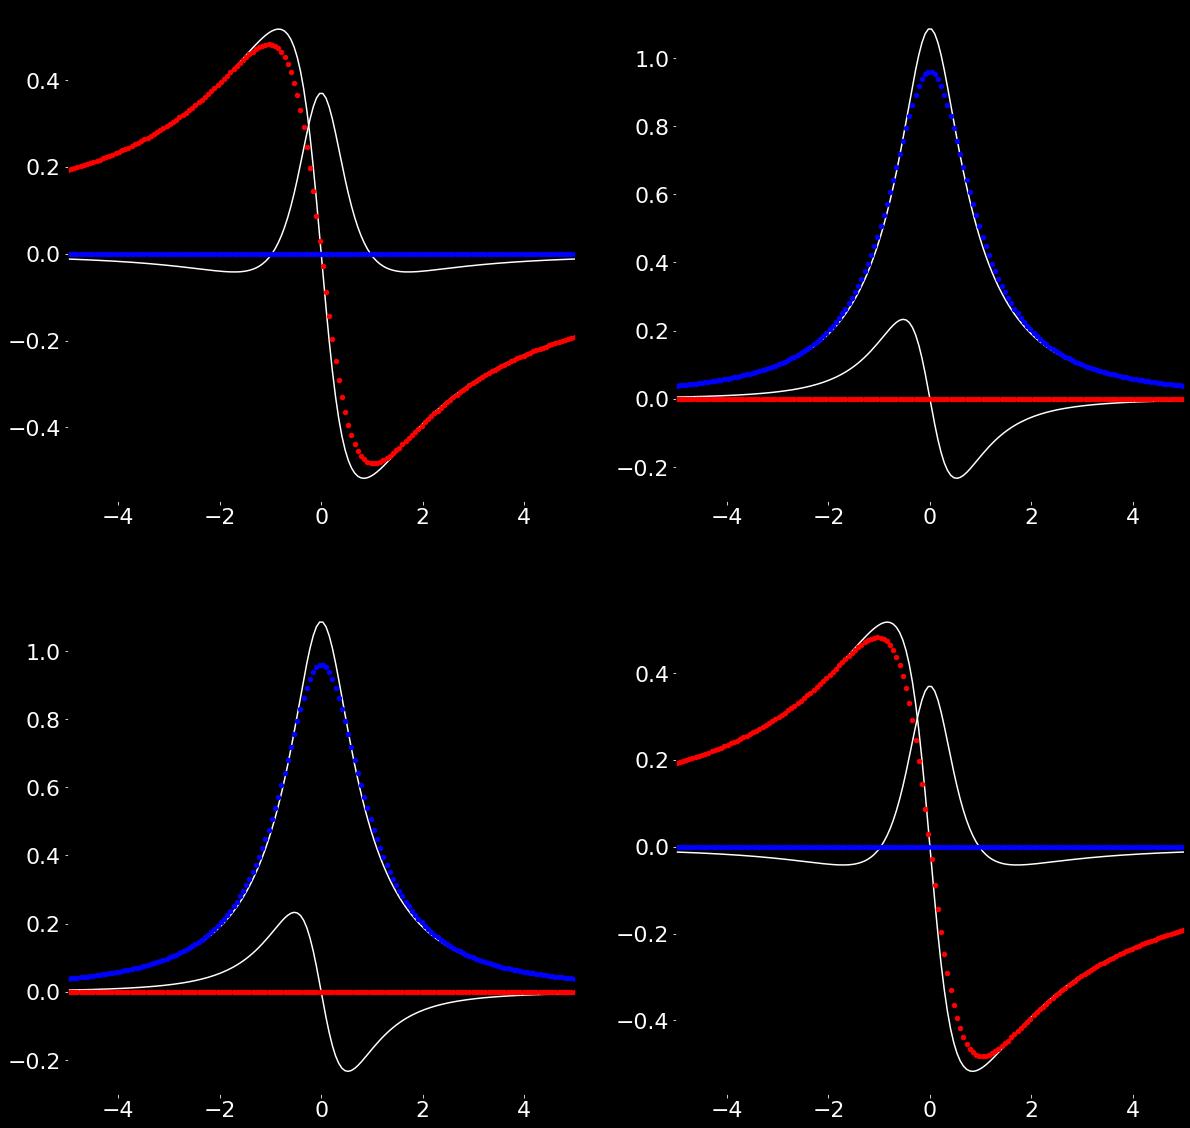

In [13]:
orbitals = 2
N_fix = 2

non_local = False
t = 1.0
U = 0.7
beta = 100

N_tol = 1e-5
max_iter = 25

mu_0 = 0
mu_gw =  0


tij = np.zeros([orbitals] * 2)
for i in range(orbitals - 1):
    tij[i, i + 1] = -t
    tij[i + 1, i] = -t

Vij = coulomb_matrix(orbitals, U, non_local = non_local)
Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)

iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)
g0_w = generate_g0_w(tij, iw_mesh_f)
# print(N(g0_w))

ED, mu_1 = exact_diag(tij, Vijkl, N_fix = N_fix, beta = beta, nw = 1024, N_tol = N_tol, mu = 0.0)

gw = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, N_fix = N_fix, max_iter = max_iter, full_mesh = True, N_tol = N_tol, mu_0 = 0.0, mu_gw = 0.0)
gw2 = GWSolver(g0_w, Vij, self_interactions = False, hartree_flag = True, fock_flag = True, N_fix = False, max_iter = max_iter, full_mesh = True, N_tol = N_tol, mu_0 = 0.0, mu_gw = 0.0)


# ED, mu_1, mu_2 = exact_diag_v(tij, Vijkl, N_0_fix = False, N_gw_fix = False, beta = beta, nw = 1024, N_tol = N_tol, mu_0 = 0, mu_gw = 0)
# ED1, mu_11, mu_22 = exact_diag_v(tij, Vijkl, N_0_fix = False, N_gw_fix = 2, beta = beta, nw = 1024, N_tol = N_tol, mu_0 = 0, mu_gw = 0)
# print(f'g0_w occupation: {round(N(gw.g0_w), 9)}, Chemical potential: {gw.mu_0}')
# print(f'g_w occupation: {round(N(gw.g_w), 9)}, Chemical potential: {gw.mu_gw}')
print(f'ED occupation: {round(N(ED), 9)}, Chemical potential: {mu_1}')
print(f'GW occupation: {round(N(gw.g_w), 9)}, Chemical potential: {gw.mu_gw}')
plot(gw.g_w, ED)
# print(f'Iteration reached: {gw.iter_reached}')

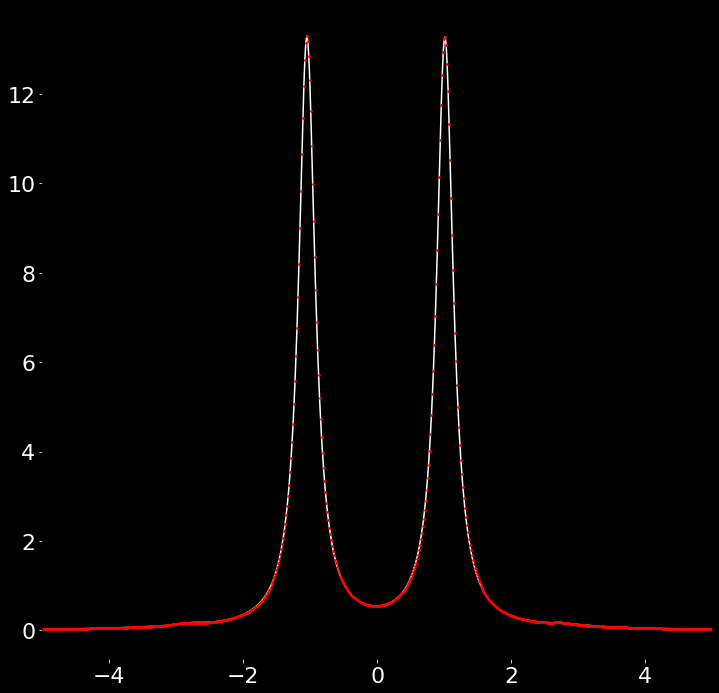

In [12]:
w_mesh = MeshReFreq(window = (-15, 15), n_w = 1 * 2048)
w = np.array([W for W in w_mesh.values()])

w_min = -5
w_max = -w_min

w_min_arg = np.argmin(np.abs(w - w_min))
w_max_arg = np.argmin(np.abs(w - w_max))
w_center_arg = np.argmin(np.abs(w))


G_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
G_w = BlockGf(block_list = [G_w_temp] * 2, name_list = ['up', 'dn'])
for block, g in G_w:
    G_w[block].set_from_pade(gw2.g_w[block], n_points = 100, freq_offset = 0.15)

g_w_temp = Gf(mesh = w_mesh, target_shape = [orbitals, orbitals])
g_w = BlockGf(block_list = [g_w_temp] * 2, name_list = ['up', 'dn'])
for block, g in G_w:
    g_w[block].set_from_pade(gw.g_w[block], n_points = 100, freq_offset = 0.15)


G_w_offset = 1 * offset(G_w, w, w_center_arg)
g_w_offset = 1 * offset(g_w, w, w_center_arg)

fig, ax = plt.subplots(1, figsize = (12, 12), facecolor = 'black')
ax.xaxis.label.set_fontsize(20)
ax.set_facecolor('black')
ax.xaxis.label.set_color('white')
ax.tick_params(axis = 'x', colors = 'white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis = 'y', colors = 'white')
ax.set_xlim(w_min, w_max)

ax.plot([w for w in G_w.mesh.values()][w_min_arg:w_max_arg], spectral(G_w)[w_min_arg + G_w_offset:w_max_arg + G_w_offset], color = 'white', zorder = 0)
ax.scatter([w for w in g_w.mesh.values()][w_min_arg:w_max_arg], spectral(g_w)[w_min_arg + g_w_offset:w_max_arg + g_w_offset], color = 'red', s = 3, zorder = 1)
plt.show()

In [6]:
# orbitals_list = np.arange(1, 100, 1)
# diffs = []
# for orbitals in orbitals_list:
#     orbitals = 3
#     beta = 100
#     iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 20.0, eps = 1e-12, symmetrize = True)
#     g0_w = generate_g0_w(tij, iw_mesh_f)
#     diffs.append(np.abs(N(g0_w) - orbitals))
# print(np.max(diffs))